<a href="https://colab.research.google.com/github/BhanuDanda/NLP/blob/main/lab_test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_fscore_support

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

df = pd.read_csv("/content/tweets.csv")



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess(text):
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove links
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

df["clean_text"] = df["text"].apply(preprocess)


In [5]:

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["clean_text"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


y_train_cat = to_categorical(y_train, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train.toarray(), y_train_cat, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

y_pred_nn = np.argmax(model.predict(X_test.toarray()), axis=1)

print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1878
           1       0.87      0.41      0.56       396

    accuracy                           0.89      2274
   macro avg       0.88      0.70      0.75      2274
weighted avg       0.89      0.89      0.87      2274



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7676 - loss: 0.5458 - val_accuracy: 0.8088 - val_loss: 0.3616
Epoch 2/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8777 - loss: 0.2772 - val_accuracy: 0.8703 - val_loss: 0.3373
Epoch 3/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9460 - loss: 0.1502 - val_accuracy: 0.8692 - val_loss: 0.3801
Epoch 4/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9703 - loss: 0.0923 - val_accuracy: 0.8593 - val_loss: 0.4703
Epoch 5/5
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9845 - loss: 0.0513 - val_accuracy: 0.8626 - val_loss: 0.5406
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94      1878
           1       0.72      0.62      0.67       396

    accuracy                           0.89      2274
   macro avg       0.82      0.79      0.80      2274
weighted av

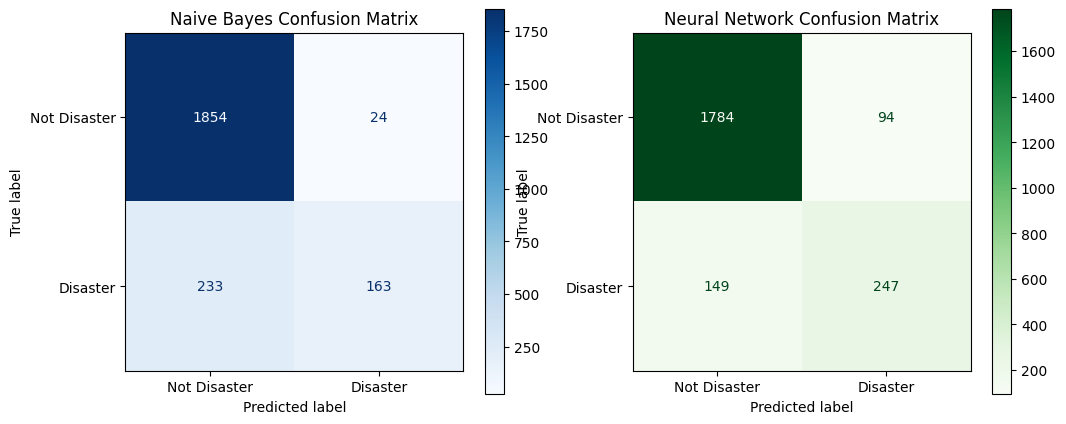

In [14]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_nb = confusion_matrix(y_test, y_pred_nb)
ConfusionMatrixDisplay(cm_nb, display_labels=["Not Disaster", "Disaster"]).plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Naive Bayes Confusion Matrix")

cm_nn = confusion_matrix(y_test, y_pred_nn)
ConfusionMatrixDisplay(cm_nn, display_labels=["Not Disaster", "Disaster"]).plot(ax=axes[1], cmap="Greens")
axes[1].set_title("Neural Network Confusion Matrix")

plt.show()



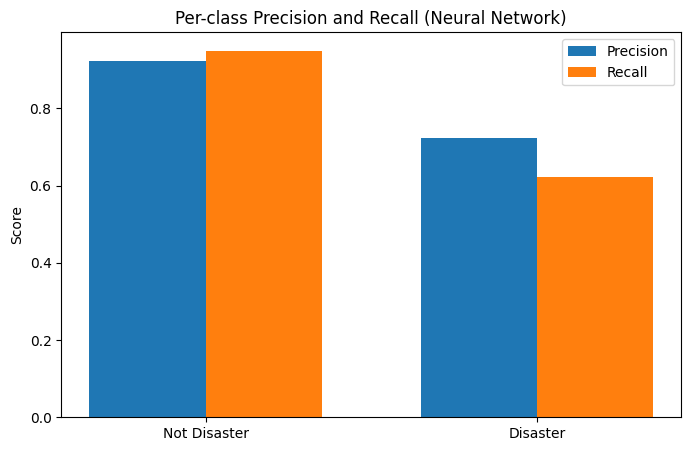

In [12]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_nn, average=None, labels=[0,1])
classes = ["Not Disaster", "Disaster"]

x = np.arange(len(classes))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(x - width/2, prec, width, label="Precision")
ax.bar(x + width/2, rec, width, label="Recall")

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel("Score")
ax.set_title("Per-class Precision and Recall (Neural Network)")
ax.legend()
plt.show()
